### Understanding Visual Agnosia with Computer Vision

**Neuro140 Final Project**

**Bianca Cordazzo**

In [218]:
## Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

import random  
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sns

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


### Test 3:
Use ***finetuning*** to optimize the model's performance. As we will see below, this was the most successful model among the 3 tested. Therefore, I continued with it for the rest of the project.


To see Tests 1 and 2, please refer to *Initial Tests* file.

In [2]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Data normalization for training and validation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
# Create training and validation datasets
trainset = torchvision.datasets.CIFAR10(root = "./data/train/", train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root = "./data/test/", train=False,
                                       download=True, transform=transform)

# Create training and validation dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

class_list = []
for i in classes:
    class_list.append(i)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images))

# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# Data directory
data_dir = "./data"

# Model to be using
model_name = "resnet18"

# "Number of classes in the dataset"
num_classes = 10

# "Number of epochs to train for"
num_epochs = 20

# "Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params"
feature_extract = False

In [5]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(512, num_classes)
        input_size = 224
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# #Initialize the model for this run#
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract,
                                        use_pretrained=True)

# #Print the model we just instantiated#
# print(model_ft)

In [7]:
# References: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#             https://blog.paperspace.com/pytorch-101-building-neural-networks/
#             https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs):
    
    epoch_losses = []
    epoch_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        epoch_loss = 0.0
        losses = []
        
        # Train
        start = time.time()
        for batch_idx, data in enumerate(trainloader):
            inputs, targets = data

            optimizer.zero_grad()                 # Zero the gradients

            outputs = model(inputs)               # Forward pass
            loss = criterion(outputs, targets)    # Compute the Loss
            loss.backward()                       # Compute the Gradients
            optimizer.step()                      # Updated the weights
            
            losses.append(loss.item())
            end = time.time()
                
        epoch_loss += outputs.shape[0] * loss.item()
        epoch_losses.append(epoch_loss/len(trainset))
        print('Train loss : %.3f' % (epoch_loss))
        
        # Evaluate
        model.eval()
        total = 0
        correct = 0

        with torch.no_grad():
            for batch_idx, data in enumerate(testloader):
                inputs, targets = data

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum()

            epoch_acc.append(100.*correct/total)
            print('Test Acc : %.3f' % (100.*correct/total))
            print('--------------------------------------------------------------')
        model.train() 
        
    return model, epoch_losses, epoch_acc

In [8]:
# References: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#             https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Setup optimizer
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss function
criterion = nn.CrossEntropyLoss()

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [75]:
def gen_accuracy(model):
    # Calculates the network's performance on the whole dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    acc = 100 * correct / total
    
    return acc

In [10]:
def accuracies(model):
    # Calculates the network's performance across all classes
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    acc_hist = []
    print("Accuracy of the network on the 10 classes")
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        acc_hist.append(100 * class_correct[i] / class_total[i])
        
    return acc_hist

In [12]:
# functions that plot the training losses and test accuracies vs. epochs.
def plot_losses(losses):
    plt.plot(epoch_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Train losses')
    plt.show()
    
def plot_acc(acc):
    plt.plot(acc)
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.show()

In [11]:
# Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# Train and evaluate
model_ft, epoch_losses, epoch_acc = train_model(model_ft, trainloader, 
                                                testloader, criterion, 
                                                optimizer_ft, num_epochs=num_epochs)

Epoch 1/20
----------
Train loss : 99.340
Test Acc : 66.330
--------------------------------------------------------------
Epoch 2/20
----------
Train loss : 63.691
Test Acc : 71.260
--------------------------------------------------------------
Epoch 3/20
----------
Train loss : 44.705
Test Acc : 73.360
--------------------------------------------------------------
Epoch 4/20
----------
Train loss : 44.613
Test Acc : 74.710
--------------------------------------------------------------
Epoch 5/20
----------
Train loss : 53.593
Test Acc : 75.470
--------------------------------------------------------------
Epoch 6/20
----------
Train loss : 42.361
Test Acc : 75.790
--------------------------------------------------------------
Epoch 7/20
----------
Train loss : 21.527
Test Acc : 75.570
--------------------------------------------------------------
Epoch 8/20
----------
Train loss : 28.763
Test Acc : 76.050
--------------------------------------------------------------
Epoch 9/20
-----

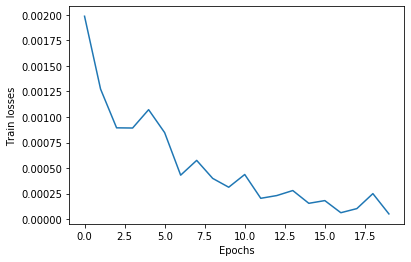

In [13]:
plot_losses(epoch_losses)

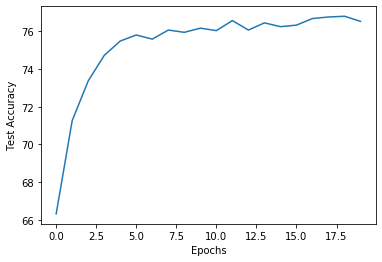

In [14]:
plot_acc(epoch_acc)

In [107]:
# print model's overall accuracy
original_acc = gen_accuracy(model_ft)

Accuracy of the network on the 10000 test images: 75 %


In [16]:
# print model's accuracy across different classes
acc_hist = accuracies(model_ft)

Accuracy of the network on the 10 classes
Accuracy of plane : 68 %
Accuracy of   car : 100 %
Accuracy of  bird : 92 %
Accuracy of   cat : 45 %
Accuracy of  deer : 69 %
Accuracy of   dog : 53 %
Accuracy of  frog : 72 %
Accuracy of horse : 83 %
Accuracy of  ship : 85 %
Accuracy of truck : 88 %


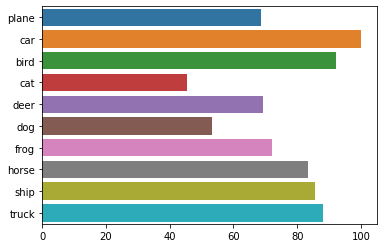

In [17]:
# barplot displaying model's performance
ax = sns.barplot(x=acc_hist, y=class_list)

In [18]:
# Save model
PATH = './cifar_net.pth'
torch.save(model_ft.state_dict(), PATH)

In [20]:
# load model
# model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
# save the model's state_dict into a variable
state_dict = model_ft.state_dict()

### Model's Architecture
Below we explore layer dimensions in order to select layers and sublayers to be modified in the Experiments Section.

In [25]:
layer = state_dict['conv1.weight']
bn1_weight = state_dict['bn1.weight']
bn1_bias = state_dict['bn1.bias']

print('Conv1.weight:', len(layer), len(layer[0]),  len(layer[0][0]), len(layer[0][0][0]))
print('bn1.weight', len(bn1_weight))
print('bn1.bias', len(bn1_bias))

Conv1.weight: 64 3 7 7
bn1.weight 64
bn1.bias 64


### Layer 1

In [26]:
print("Conv1")
layer1_0 = state_dict['layer1.0.conv1.weight']
layer1_1 = state_dict['layer1.1.conv1.weight']

print('layer 1.0:', len(layer1_0), len(layer1_0[0]),  len(layer1_0[0][0]), len(layer1_0[0][0][0]))
print('layer 1.1:', len(layer1_1), len(layer1_1[0]),  len(layer1_1[0][0]), len(layer1_1[0][0][0]))
print()

print("Conv2")
layer1_0 = state_dict['layer1.0.conv2.weight']
layer1_1 = state_dict['layer1.1.conv2.weight']

print('layer 1.0:', len(layer1_0), len(layer1_0[0]),  len(layer1_0[0][0]), len(layer1_0[0][0][0]))
print('layer 1.1:', len(layer1_1), len(layer1_1[0]),  len(layer1_1[0][0]), len(layer1_1[0][0][0]))

Conv1
layer 1.0: 64 64 3 3
layer 1.1: 64 64 3 3

Conv2
layer 1.0: 64 64 3 3
layer 1.1: 64 64 3 3


### Layer 2

In [27]:
print("Conv1")
layer2_0 = state_dict['layer2.0.conv1.weight']
layer2_1 = state_dict['layer2.1.conv1.weight']

print('layer 2.0:', len(layer2_0), len(layer2_0[0]),  len(layer2_0[0][0]), len(layer2_0[0][0][0]))
print('layer 2.1:', len(layer2_1), len(layer2_1[0]),  len(layer2_1[0][0]), len(layer2_1[0][0][0]))
print()

print("Conv2")
layer2_0 = state_dict['layer2.0.conv2.weight']
layer2_1 = state_dict['layer2.1.conv2.weight']

print('layer 2.0:', len(layer2_0), len(layer2_0[0]),  len(layer2_0[0][0]), len(layer2_0[0][0][0]))
print('layer 2.1:', len(layer2_1), len(layer2_1[0]),  len(layer2_1[0][0]), len(layer2_1[0][0][0]))

Conv1
layer 2.0: 128 64 3 3
layer 2.1: 128 128 3 3

Conv2
layer 2.0: 128 128 3 3
layer 2.1: 128 128 3 3


### Layer 3

In [28]:
print("Conv1")
layer3_0 = state_dict['layer3.0.conv1.weight']
layer3_1 = state_dict['layer3.1.conv1.weight']

print('layer 3.0:', len(layer3_0), len(layer3_0[0]),  len(layer3_0[0][0]), len(layer3_0[0][0][0]))
print('layer 3.1:', len(layer3_1), len(layer3_1[0]),  len(layer3_1[0][0]), len(layer3_1[0][0][0]))
print()

print("Conv2")
layer3_0 = state_dict['layer3.0.conv2.weight']
layer3_1 = state_dict['layer3.1.conv2.weight']

print('layer 3.0:', len(layer3_0), len(layer3_0[0]),  len(layer3_0[0][0]), len(layer3_0[0][0][0]))
print('layer 3.1:', len(layer3_1), len(layer3_1[0]),  len(layer3_1[0][0]), len(layer3_1[0][0][0]))

Conv1
layer 3.0: 256 128 3 3
layer 3.1: 256 256 3 3

Conv2
layer 3.0: 256 256 3 3
layer 3.1: 256 256 3 3


### Layer 4

In [29]:
print("Conv1")
layer4_0 = state_dict['layer4.0.conv1.weight']
layer4_1 = state_dict['layer4.1.conv1.weight']

print('layer 4.0:', len(layer4_0), len(layer4_0[0]),  len(layer4_0[0][0]), len(layer4_0[0][0][0]))
print('layer 4.1:', len(layer4_1), len(layer4_1[0]),  len(layer4_1[0][0]), len(layer4_1[0][0][0]))
print()

print("Conv2")
layer4_0 = state_dict['layer4.0.conv2.weight']
layer4_1 = state_dict['layer4.1.conv2.weight']

print('layer 4.0:', len(layer4_0), len(layer4_0[0]),  len(layer4_0[0][0]), len(layer4_0[0][0][0]))
print('layer 4.1:', len(layer4_1), len(layer4_1[0]),  len(layer4_1[0][0]), len(layer4_1[0][0][0]))

Conv1
layer 4.0: 512 256 3 3
layer 4.1: 512 512 3 3

Conv2
layer 4.0: 512 512 3 3
layer 4.1: 512 512 3 3


## Experiments Section

### Deep copy model before manipulation
This will prevent the original model's weights to be modified when running the experiments.

In [30]:
manipulated_model1 = copy.deepcopy(model_ft)
manipulated_model2 = copy.deepcopy(model_ft)
manipulated_model3 = copy.deepcopy(model_ft)
manipulated_model4 = copy.deepcopy(model_ft)

# stores state_dict of all soon-to-be manipulated models
manipulated_dict1 = manipulated_model1.state_dict()
manipulated_dict2 = manipulated_model2.state_dict()
manipulated_dict3 = manipulated_model3.state_dict()
manipulated_dict4 = manipulated_model4.state_dict()

In [54]:
# creates ablated layers (all weights = 0), which will be inserted 
# in appropriate sublayers or layers later on.
ablation_layer1 = torch.zeros(64, 64, 3, 3)
ablation_layer2 = torch.zeros(128, 128, 3, 3)
ablation_layer3 = torch.zeros(256, 256, 3, 3)
ablation_layer4 = torch.zeros(512, 512, 3, 3)

## Ablation of *layern.0.conv2.weight*
### Ablation: Layer 1

In [45]:
# ablate layer 1
manipulated_dict1['layer1.0.conv2.weight'] = ablation_layer1

# sanity check
# manipulated_dict1['layer1.0.conv2.weight']

# load ablated model
manipulated_model1.load_state_dict(manipulated_dict1)

# sanity check
# manipulated_model1.state_dict()

<All keys matched successfully>

In [76]:
# prints overall and class-specific accuracies
gen_acc1 = gen_accuracy(manipulated_model1)
print()
acc_hist1 = accuracies(manipulated_model1)

Accuracy of the network on the 10000 test images: 66 %

Accuracy of the network on the 10 classes
Accuracy of plane : 56 %
Accuracy of   car : 84 %
Accuracy of  bird : 76 %
Accuracy of   cat : 40 %
Accuracy of  deer : 61 %
Accuracy of   dog : 26 %
Accuracy of  frog : 66 %
Accuracy of horse : 66 %
Accuracy of  ship : 76 %
Accuracy of truck : 82 %


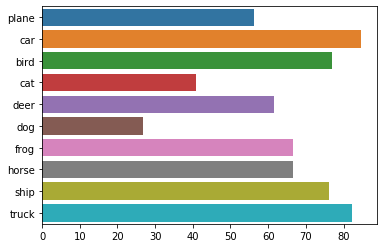

In [59]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax1 = sns.barplot(x=acc_hist1, y=class_list)

### Ablation: Layer 2

In [56]:
# ablate layer 2
manipulated_dict2['layer2.0.conv2.weight'] = ablation_layer2

# sanity check
# manipulated_dict2['layer2.0.conv2.weight']

# load ablated model
manipulated_model2.load_state_dict(manipulated_dict2)

# sanity check
# manipulated_model2.state_dict()

<All keys matched successfully>

In [78]:
# prints overall and class-specific accuracies
gen_acc2 = gen_accuracy(manipulated_model2)
print()
acc_hist2 = accuracies(manipulated_model2)

Accuracy of the network on the 10000 test images: 59 %

Accuracy of the network on the 10 classes
Accuracy of plane : 50 %
Accuracy of   car : 61 %
Accuracy of  bird : 69 %
Accuracy of   cat : 22 %
Accuracy of  deer : 53 %
Accuracy of   dog : 46 %
Accuracy of  frog : 55 %
Accuracy of horse : 50 %
Accuracy of  ship : 71 %
Accuracy of truck : 70 %


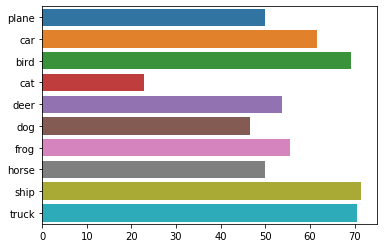

In [58]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax2 = sns.barplot(x=acc_hist2, y=class_list)

### Ablation: Layer 3

In [61]:
# ablate layer 3
manipulated_dict3['layer3.0.conv2.weight'] = ablation_layer3

# sanity check
# manipulated_dict3['layer3.0.conv2.weight']

# load ablated model
manipulated_model3.load_state_dict(manipulated_dict3)

# sanity check
# manipulated_model3.state_dict()

<All keys matched successfully>

In [79]:
# prints overall and class-specific accuracies
gen_acc3 = gen_accuracy(manipulated_model3)
print()
acc_hist3 = accuracies(manipulated_model3)

Accuracy of the network on the 10000 test images: 33 %

Accuracy of the network on the 10 classes
Accuracy of plane : 31 %
Accuracy of   car : 38 %
Accuracy of  bird : 61 %
Accuracy of   cat : 22 %
Accuracy of  deer : 15 %
Accuracy of   dog : 13 %
Accuracy of  frog : 27 %
Accuracy of horse : 50 %
Accuracy of  ship : 42 %
Accuracy of truck : 23 %


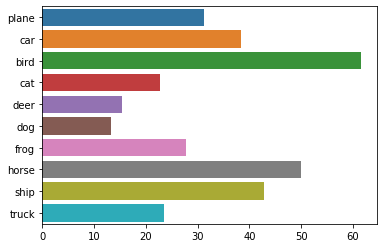

In [64]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax3 = sns.barplot(x=acc_hist3, y=class_list)

### Ablation: Layer 4

In [65]:
# ablate layer 4
manipulated_dict4['layer4.0.conv2.weight'] = ablation_layer4

# sanity check
# manipulated_dict4['layer4.0.conv2.weight']

# load ablated model
manipulated_model4.load_state_dict(manipulated_dict4)

# sanity check
# manipulated_model4.state_dict()

<All keys matched successfully>

In [80]:
# prints overall and class-specific accuracies
gen_acc4 = gen_accuracy(manipulated_model4)
print()
acc_hist4 = accuracies(manipulated_model4)

Accuracy of the network on the 10000 test images: 53 %

Accuracy of the network on the 10 classes
Accuracy of plane : 56 %
Accuracy of   car : 69 %
Accuracy of  bird : 46 %
Accuracy of   cat : 31 %
Accuracy of  deer : 53 %
Accuracy of   dog : 20 %
Accuracy of  frog : 61 %
Accuracy of horse : 41 %
Accuracy of  ship : 42 %
Accuracy of truck : 70 %


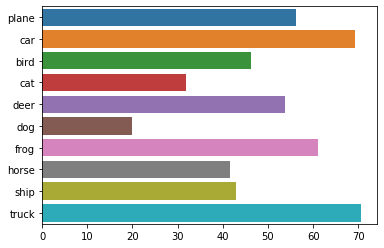

In [67]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax4 = sns.barplot(x=acc_hist4, y=class_list)

### Broad Interpretation

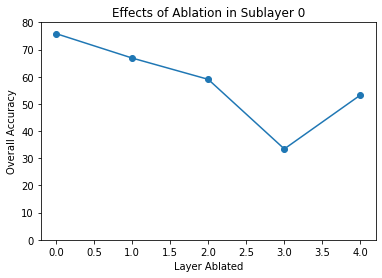

In [255]:
# compares all of the ablated models performance 
# Note: Layer 0 = Origial Model's Performance
accs = [original_acc, gen_acc1, gen_acc2, gen_acc3, gen_acc4]
layers = [0, 1, 2, 3, 4]

plt.plot(layers, accs, marker='o')
plt.ylim(0,80)
plt.title("Effects of Ablation in Sublayer 0")
plt.xlabel("Layer Ablated")
plt.ylabel("Overall Accuracy")
plt.show()

In [259]:
all_accuracies = [acc_hist, acc_hist1, acc_hist2, acc_hist3, acc_hist4]

plane_acc = [] ;  dog_acc = []
car_acc = []   ;  frog_acc = []
bird_acc = []  ;  horse_acc = []
cat_acc = []   ;  ship_acc = []
deer_acc = []  ;  truck_acc = []

for i in all_accuracies:
    plane_acc.append(i[0])
    car_acc.append(i[1])
    bird_acc.append(i[2])
    cat_acc.append(i[3])
    deer_acc.append(i[4])
    dog_acc.append(i[5])
    frog_acc.append(i[6])
    horse_acc.append(i[7])
    ship_acc.append(i[8])
    truck_acc.append(i[9])

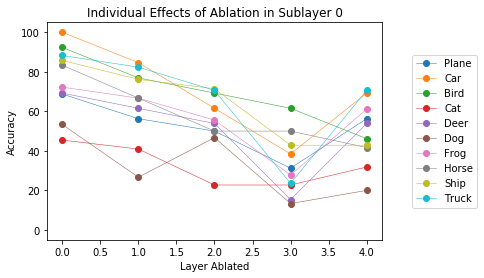

In [260]:
plt.plot(layers, plane_acc, marker='o', linewidth=0.5, label = 'Plane')
plt.plot(layers, car_acc, marker='o', linewidth=0.5, label = 'Car')
plt.plot(layers, bird_acc, marker='o', linewidth=0.5, label = 'Bird')
plt.plot(layers, cat_acc, marker='o', linewidth=0.5, label = 'Cat')
plt.plot(layers, deer_acc, marker='o', linewidth=0.5, label = 'Deer')
plt.plot(layers, dog_acc, marker='o', linewidth=0.5, label = 'Dog')
plt.plot(layers, frog_acc, marker='o', linewidth=0.5, label = 'Frog')
plt.plot(layers, horse_acc, marker='o', linewidth=0.5, label = 'Horse')
plt.plot(layers, ship_acc, marker='o', linewidth=0.5, label = 'Ship')
plt.plot(layers, truck_acc, marker='o', linewidth=0.5, label = 'Truck')

plt.ylim(-5,105)
plt.title("Individual Effects of Ablation in Sublayer 0")
plt.xlabel("Layer Ablated")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='right')
plt.show()

## Ablation of *layern.1.conv2.weight*

In [166]:
manipulated_model1_1 = copy.deepcopy(model_ft)
manipulated_model2_1 = copy.deepcopy(model_ft)
manipulated_model3_1 = copy.deepcopy(model_ft)
manipulated_model4_1 = copy.deepcopy(model_ft)

# stores state_dict of all soon-to-be manipulated models
manipulated_dict1_1 = manipulated_model1_1.state_dict()
manipulated_dict2_1 = manipulated_model2_1.state_dict()
manipulated_dict3_1 = manipulated_model3_1.state_dict()
manipulated_dict4_1 = manipulated_model4_1.state_dict()

ablation_layer1 = torch.zeros(64, 64, 3, 3)
ablation_layer2 = torch.zeros(128, 128, 3, 3)
ablation_layer3 = torch.zeros(256, 256, 3, 3)
ablation_layer4 = torch.zeros(512, 512, 3, 3)

### Ablation: Layer 1

In [168]:
# ablate layer 1
manipulated_dict1_1['layer1.1.conv2.weight'] = ablation_layer1

# sanity check
# manipulated_dict1_1['layer1.1.conv2.weight']

# load ablated model
manipulated_model1_1.load_state_dict(manipulated_dict1_1)

# sanity check
# manipulated_model1_1.state_dict()

<All keys matched successfully>

In [169]:
# prints overall and class-specific accuracies
gen_acc1_1 = gen_accuracy(manipulated_model1_1)
print()
acc_hist1_1 = accuracies(manipulated_model1_1)

Accuracy of the network on the 10000 test images: 70 %

Accuracy of the network on the 10 classes
Accuracy of plane : 56 %
Accuracy of   car : 92 %
Accuracy of  bird : 61 %
Accuracy of   cat : 40 %
Accuracy of  deer : 53 %
Accuracy of   dog : 46 %
Accuracy of  frog : 77 %
Accuracy of horse : 75 %
Accuracy of  ship : 71 %
Accuracy of truck : 70 %


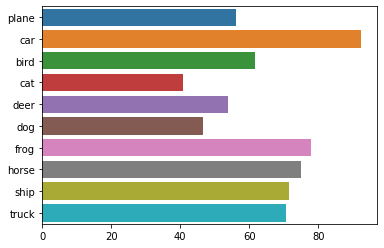

In [170]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax1_1 = sns.barplot(x=acc_hist1_1, y=class_list)

### Ablation: Layer 2

In [171]:
# ablate layer 2
manipulated_dict2_1['layer2.1.conv2.weight'] = ablation_layer2

# sanity check
# manipulated_dict2_1['layer2.1.conv2.weight']

# load ablated model
manipulated_model2_1.load_state_dict(manipulated_dict2_1)

# sanity check
# manipulated_model2_1.state_dict()

<All keys matched successfully>

In [172]:
# prints overall and class-specific accuracies
gen_acc2_1 = gen_accuracy(manipulated_model2_1)
print()
acc_hist2_1 = accuracies(manipulated_model2_1)

Accuracy of the network on the 10000 test images: 66 %

Accuracy of the network on the 10 classes
Accuracy of plane : 43 %
Accuracy of   car : 84 %
Accuracy of  bird : 76 %
Accuracy of   cat : 50 %
Accuracy of  deer : 53 %
Accuracy of   dog : 26 %
Accuracy of  frog : 72 %
Accuracy of horse : 66 %
Accuracy of  ship : 76 %
Accuracy of truck : 82 %


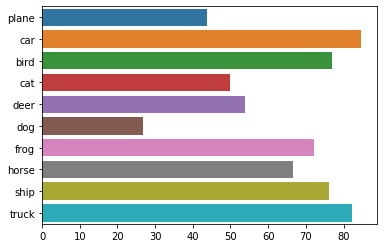

In [174]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax2_1 = sns.barplot(x=acc_hist2_1, y=class_list)

### Ablation: Layer 3

In [175]:
# ablate layer 3
manipulated_dict3_1['layer3.1.conv2.weight'] = ablation_layer3

# sanity check
# manipulated_dict3_1['layer3.1.conv2.weight']

# load ablated model
manipulated_model3_1.load_state_dict(manipulated_dict3_1)

# sanity check
# manipulated_model3_1.state_dict()

<All keys matched successfully>

In [176]:
# prints overall and class-specific accuracies
gen_acc3_1 = gen_accuracy(manipulated_model3_1)
print()
acc_hist3_1 = accuracies(manipulated_model3_1)

Accuracy of the network on the 10000 test images: 71 %

Accuracy of the network on the 10 classes
Accuracy of plane : 75 %
Accuracy of   car : 92 %
Accuracy of  bird : 61 %
Accuracy of   cat : 54 %
Accuracy of  deer : 53 %
Accuracy of   dog : 33 %
Accuracy of  frog : 83 %
Accuracy of horse : 91 %
Accuracy of  ship : 71 %
Accuracy of truck : 82 %


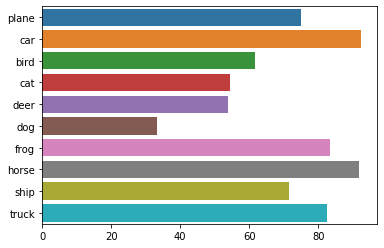

In [177]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax3_1 = sns.barplot(x=acc_hist3_1, y=class_list)

### Ablation: Layer 4

In [178]:
# ablate layer 4
manipulated_dict4_1['layer4.1.conv2.weight'] = ablation_layer4

# sanity check
# manipulated_dict4_1['layer4.1.conv2.weight']

# load ablated model
manipulated_model4_1.load_state_dict(manipulated_dict4_1)

# sanity check
# manipulated_model4_1.state_dict()

<All keys matched successfully>

In [179]:
# prints overall and class-specific accuracies
gen_acc4_1 = gen_accuracy(manipulated_model4_1)
print()
acc_hist4_1 = accuracies(manipulated_model4_1)

Accuracy of the network on the 10000 test images: 43 %

Accuracy of the network on the 10 classes
Accuracy of plane : 43 %
Accuracy of   car : 61 %
Accuracy of  bird : 61 %
Accuracy of   cat : 40 %
Accuracy of  deer :  0 %
Accuracy of   dog : 40 %
Accuracy of  frog :  0 %
Accuracy of horse : 66 %
Accuracy of  ship :  4 %
Accuracy of truck : 52 %


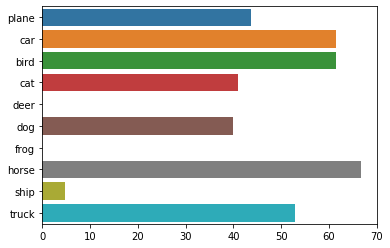

In [180]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax4_1 = sns.barplot(x=acc_hist4_1, y=class_list)

### Broad Interpretation

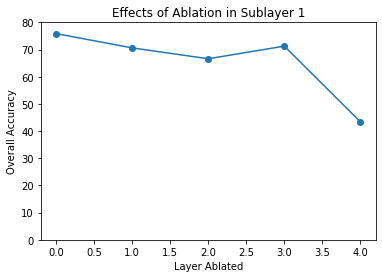

In [256]:
# compares all of the ablated models performance 
# Note: Layer 0 = Origial Model's Performance

accs_1 = [original_acc, gen_acc1_1, gen_acc2_1, gen_acc3_1, gen_acc4_1]
layers = [0, 1, 2, 3, 4]

plt.plot(layers, accs_1, marker='o')
plt.ylim(0,80)
plt.title("Effects of Ablation in Sublayer 1")
plt.xlabel("Layer Ablated")
plt.ylabel("Overall Accuracy")
plt.show()

In [261]:
all_accuracies_1 = [acc_hist, acc_hist1_1, acc_hist2_1, acc_hist3_1, acc_hist4_1]

plane_acc = [] ;  dog_acc = []
car_acc = []   ;  frog_acc = []
bird_acc = []  ;  horse_acc = []
cat_acc = []   ;  ship_acc = []
deer_acc = []  ;  truck_acc = []

for i in all_accuracies_1:
    plane_acc.append(i[0])
    car_acc.append(i[1])
    bird_acc.append(i[2])
    cat_acc.append(i[3])
    deer_acc.append(i[4])
    dog_acc.append(i[5])
    frog_acc.append(i[6])
    horse_acc.append(i[7])
    ship_acc.append(i[8])
    truck_acc.append(i[9])

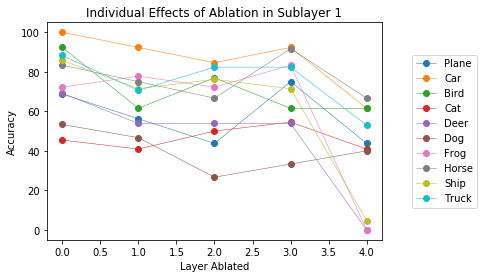

In [262]:
# Plotting
plt.plot(layers, plane_acc, marker='o', linewidth=0.5, label = 'Plane')
plt.plot(layers, car_acc, marker='o', linewidth=0.5, label = 'Car')
plt.plot(layers, bird_acc, marker='o', linewidth=0.5, label = 'Bird')
plt.plot(layers, cat_acc, marker='o', linewidth=0.5, label = 'Cat')
plt.plot(layers, deer_acc, marker='o', linewidth=0.5, label = 'Deer')
plt.plot(layers, dog_acc, marker='o', linewidth=0.5, label = 'Dog')
plt.plot(layers, frog_acc, marker='o', linewidth=0.5, label = 'Frog')
plt.plot(layers, horse_acc, marker='o', linewidth=0.5, label = 'Horse')
plt.plot(layers, ship_acc, marker='o', linewidth=0.5, label = 'Ship')
plt.plot(layers, truck_acc, marker='o', linewidth=0.5, label = 'Truck')

plt.ylim(-5,105)
plt.title("Individual Effects of Ablation in Sublayer 1")
plt.xlabel("Layer Ablated")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='right')
plt.show()

### Ablating entire layers, one at a time

In [193]:
manipulated_model1_complete = copy.deepcopy(model_ft)
manipulated_model2_complete = copy.deepcopy(model_ft)
manipulated_model3_complete = copy.deepcopy(model_ft)
manipulated_model4_complete = copy.deepcopy(model_ft)

# stores state_dict of all soon-to-be manipulated models
manipulated_dict1_complete = manipulated_model1_complete.state_dict()
manipulated_dict2_complete = manipulated_model2_complete.state_dict()
manipulated_dict3_complete = manipulated_model3_complete.state_dict()
manipulated_dict4_complete = manipulated_model4_complete.state_dict()

ablation_layer1 = torch.zeros(64, 64, 3, 3)
ablation_layer2 = torch.zeros(128, 128, 3, 3)
ablation_layer3 = torch.zeros(256, 256, 3, 3)
ablation_layer4 = torch.zeros(512, 512, 3, 3)

### Ablation: Layer 1

In [194]:
# ablate layer 1
manipulated_dict1_complete['layer1.0.conv2.weight'] = ablation_layer1
manipulated_dict1_complete['layer1.1.conv2.weight'] = ablation_layer1

# load ablated model
manipulated_model1_complete.load_state_dict(manipulated_dict1_complete)

# sanity check
# manipulated_model1_complete.state_dict()

<All keys matched successfully>

In [195]:
# prints overall and class-specific accuracies
gen_acc1_complete = gen_accuracy(manipulated_model1_complete)
print()
acc_hist1_complete = accuracies(manipulated_model1_complete)

Accuracy of the network on the 10000 test images: 52 %

Accuracy of the network on the 10 classes
Accuracy of plane : 31 %
Accuracy of   car : 53 %
Accuracy of  bird : 53 %
Accuracy of   cat : 36 %
Accuracy of  deer : 30 %
Accuracy of   dog : 66 %
Accuracy of  frog : 50 %
Accuracy of horse : 41 %
Accuracy of  ship : 66 %
Accuracy of truck : 41 %


In [ ]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
#ax1_complete = sns.barplot(x=acc_hist1_complete, y=class_list)

### Ablation: Layer 2

In [196]:
# ablate layer 2
manipulated_dict2_complete['layer2.0.conv2.weight'] = ablation_layer2
manipulated_dict2_complete['layer2.1.conv2.weight'] = ablation_layer2

# load ablated model
manipulated_model2_complete.load_state_dict(manipulated_dict2_complete)

# sanity check
# manipulated_model2_complete.state_dict()

<All keys matched successfully>

In [197]:
gen_acc2_complete = gen_accuracy(manipulated_model2_complete)
print()
acc_hist2_complete = accuracies(manipulated_model2_complete)

Accuracy of the network on the 10000 test images: 47 %

Accuracy of the network on the 10 classes
Accuracy of plane : 31 %
Accuracy of   car : 46 %
Accuracy of  bird : 53 %
Accuracy of   cat : 36 %
Accuracy of  deer : 30 %
Accuracy of   dog : 33 %
Accuracy of  frog : 77 %
Accuracy of horse : 66 %
Accuracy of  ship : 61 %
Accuracy of truck : 58 %


In [ ]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
#ax2_complete = sns.barplot(x=acc_hist2_complete, y=class_list)

### Ablation: Layer 3

In [198]:
# ablate layer 3
manipulated_dict3_complete['layer3.0.conv2.weight'] = ablation_layer3
manipulated_dict3_complete['layer3.1.conv2.weight'] = ablation_layer3

# load ablated model
manipulated_model3_complete.load_state_dict(manipulated_dict3_complete)

# sanity check
# manipulated_model3_complete.state_dict()

<All keys matched successfully>

In [199]:
# prints overall and class-specific accuracies
gen_acc3_complete = gen_accuracy(manipulated_model3_complete)
print()
acc_hist3_complete = accuracies(manipulated_model3_complete)

Accuracy of the network on the 10000 test images: 35 %

Accuracy of the network on the 10 classes
Accuracy of plane : 31 %
Accuracy of   car : 46 %
Accuracy of  bird : 46 %
Accuracy of   cat : 31 %
Accuracy of  deer : 23 %
Accuracy of   dog : 26 %
Accuracy of  frog : 50 %
Accuracy of horse :  8 %
Accuracy of  ship : 38 %
Accuracy of truck : 52 %


In [ ]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
#ax3_complete = sns.barplot(x=acc_hist3_complete, y=class_list)

### Ablation: Layer 4

In [200]:
# ablate layer 4
manipulated_dict4_complete['layer4.0.conv2.weight'] = ablation_layer4
manipulated_dict4_complete['layer4.1.conv2.weight'] = ablation_layer4

# load ablated model
manipulated_model4_complete.load_state_dict(manipulated_dict4_complete)

# sanity check
# manipulated_model4_complete.state_dict()

<All keys matched successfully>

In [263]:
# prints overall and class-specific accuracies
gen_acc4_complete = gen_accuracy(manipulated_model4_complete)
print()
acc_hist4_complete = accuracies(manipulated_model4_complete)

Accuracy of the network on the 10000 test images: 17 %

Accuracy of the network on the 10 classes
Accuracy of plane : 25 %
Accuracy of   car :  0 %
Accuracy of  bird : 46 %
Accuracy of   cat : 50 %
Accuracy of  deer :  0 %
Accuracy of   dog : 46 %
Accuracy of  frog :  0 %
Accuracy of horse :  8 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [ ]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
#ax4_complete = sns.barplot(x=acc_hist4_complete, y=class_list)

### Broad Interpretation

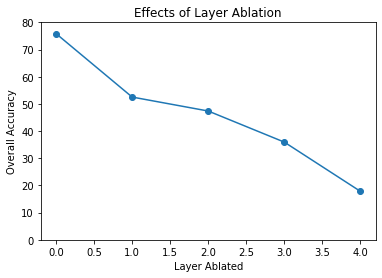

In [266]:
# compares all of the ablated models performance 
# Note: Layer 0 = Origial Model's Performance

accs_complete = [original_acc, gen_acc1_complete, gen_acc2_complete,
                 gen_acc3_complete, gen_acc4_complete]

plt.plot(layers, accs_complete, marker='o')
plt.ylim(0,80)
plt.title("Effects of Layer Ablation")
plt.xlabel("Layer Ablated")
plt.ylabel("Overall Accuracy")
plt.show()

In [268]:
all_accuracies_complete = [acc_hist, acc_hist1_complete, acc_hist2_complete,
                           acc_hist3_complete, acc_hist4_complete]

plane_acc = [] ;  dog_acc = []
car_acc = []   ;  frog_acc = []
bird_acc = []  ;  horse_acc = []
cat_acc = []   ;  ship_acc = []
deer_acc = []  ;  truck_acc = []

for i in all_accuracies_complete:
    plane_acc.append(i[0])
    car_acc.append(i[1])
    bird_acc.append(i[2])
    cat_acc.append(i[3])
    deer_acc.append(i[4])
    dog_acc.append(i[5])
    frog_acc.append(i[6])
    horse_acc.append(i[7])
    ship_acc.append(i[8])
    truck_acc.append(i[9])

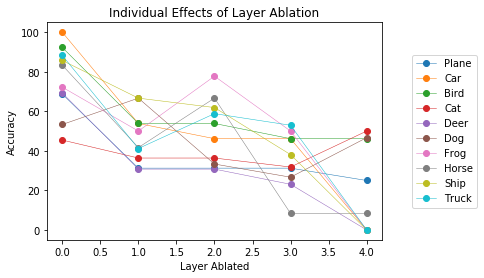

In [269]:
# Plotting
plt.plot(layers, plane_acc, marker='o', linewidth=0.5, label = 'Plane')
plt.plot(layers, car_acc, marker='o', linewidth=0.5, label = 'Car')
plt.plot(layers, bird_acc, marker='o', linewidth=0.5, label = 'Bird')
plt.plot(layers, cat_acc, marker='o', linewidth=0.5, label = 'Cat')
plt.plot(layers, deer_acc, marker='o', linewidth=0.5, label = 'Deer')
plt.plot(layers, dog_acc, marker='o', linewidth=0.5, label = 'Dog')
plt.plot(layers, frog_acc, marker='o', linewidth=0.5, label = 'Frog')
plt.plot(layers, horse_acc, marker='o', linewidth=0.5, label = 'Horse')
plt.plot(layers, ship_acc, marker='o', linewidth=0.5, label = 'Ship')
plt.plot(layers, truck_acc, marker='o', linewidth=0.5, label = 'Truck')

plt.ylim(-5,105)
plt.title("Individual Effects of Layer Ablation")
plt.xlabel("Layer Ablated")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='right')
plt.show()

### Data Augmentation/Stimulation

In [219]:
augmented_model1_complete = copy.deepcopy(model_ft)
augmented_model2_complete = copy.deepcopy(model_ft)
augmented_model3_complete = copy.deepcopy(model_ft)
augmented_model4_complete = copy.deepcopy(model_ft)

# stores state_dict of all soon-to-be manipulated models
augmented_dict1_complete = augmented_model1_complete.state_dict()
augmented_dict2_complete = augmented_model2_complete.state_dict()
augmented_dict3_complete = augmented_model3_complete.state_dict()
augmented_dict4_complete = augmented_model4_complete.state_dict()

random.seed(1) 
augmented_layer1 = torch.from_numpy(np.random.rand(64, 64, 3, 3))

random.seed(2) 
augmented_layer2 = torch.from_numpy(np.random.rand(128, 128, 3, 3))

random.seed(3) 
augmented_layer3 = torch.from_numpy(np.random.rand(256, 256, 3, 3))

random.seed(4) 
augmented_layer4 = torch.from_numpy(np.random.rand(512, 512, 3, 3))

### Augmentation: Layer 1

In [228]:
# augmented layer 1
augmented_dict1_complete['layer1.0.conv2.weight'] = augmented_layer1
augmented_dict1_complete['layer1.1.conv2.weight'] = augmented_layer1

# load augmented model
augmented_model1_complete.load_state_dict(augmented_dict1_complete)

# sanity check
# augmented_model1_complete.state_dict()

<All keys matched successfully>

In [229]:
# prints overall and class-specific accuracies
gen_acc_augmentation1 = gen_accuracy(augmented_model1_complete)
print()
ind_acc_augmentation1 = accuracies(augmented_model1_complete)

Accuracy of the network on the 10000 test images: 41 %

Accuracy of the network on the 10 classes
Accuracy of plane : 43 %
Accuracy of   car : 46 %
Accuracy of  bird : 38 %
Accuracy of   cat : 27 %
Accuracy of  deer : 38 %
Accuracy of   dog : 33 %
Accuracy of  frog : 38 %
Accuracy of horse : 33 %
Accuracy of  ship : 52 %
Accuracy of truck : 58 %


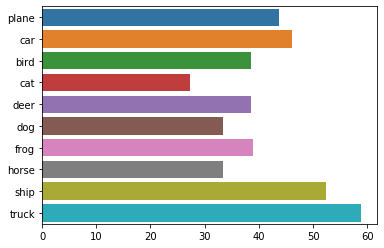

In [230]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax1_augmentation = sns.barplot(x=ind_acc_augmentation1, y=class_list)

### Augmentation: Layer 2

In [231]:
# augmented layer 2
augmented_dict2_complete['layer2.0.conv2.weight'] = augmented_layer2
augmented_dict2_complete['layer2.1.conv2.weight'] = augmented_layer2

# load augmented model
augmented_model2_complete.load_state_dict(augmented_dict2_complete)

# sanity check
# augmented_model2_complete.state_dict()

<All keys matched successfully>

In [232]:
# prints overall and class-specific accuracies
gen_acc_augmentation2 = gen_accuracy(augmented_model2_complete)
print()
ind_acc_augmentation2 = accuracies(augmented_model2_complete)

Accuracy of the network on the 10000 test images: 31 %

Accuracy of the network on the 10 classes
Accuracy of plane : 31 %
Accuracy of   car :  7 %
Accuracy of  bird : 30 %
Accuracy of   cat : 22 %
Accuracy of  deer : 15 %
Accuracy of   dog :  6 %
Accuracy of  frog : 50 %
Accuracy of horse : 41 %
Accuracy of  ship : 33 %
Accuracy of truck : 35 %


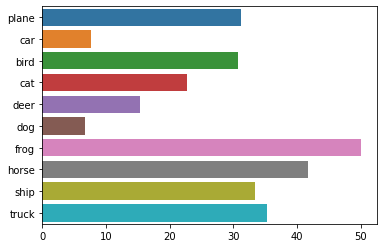

In [233]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax2_augmentation = sns.barplot(x=ind_acc_augmentation2, y=class_list)

### Augmentation: Layer 3

In [234]:
# augmented layer 3
augmented_dict3_complete['layer3.0.conv2.weight'] = augmented_layer3
augmented_dict3_complete['layer3.1.conv2.weight'] = augmented_layer3

# load augmented mode3
augmented_model3_complete.load_state_dict(augmented_dict3_complete)

# sanity check
# augmented_model3_complete.state_dict()

<All keys matched successfully>

In [235]:
# prints overall and class-specific accuracies
gen_acc_augmentation3 = gen_accuracy(augmented_model3_complete)
print()
ind_acc_augmentation3 = accuracies(augmented_model3_complete)

Accuracy of the network on the 10000 test images: 11 %

Accuracy of the network on the 10 classes
Accuracy of plane :  0 %
Accuracy of   car : 15 %
Accuracy of  bird : 46 %
Accuracy of   cat :  9 %
Accuracy of  deer : 15 %
Accuracy of   dog :  6 %
Accuracy of  frog :  0 %
Accuracy of horse : 16 %
Accuracy of  ship :  9 %
Accuracy of truck :  0 %


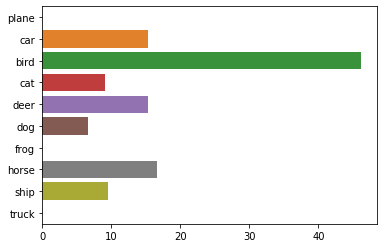

In [236]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax3_augmentation = sns.barplot(x=ind_acc_augmentation3, y=class_list)

### Augmentation: Layer 4

In [237]:
# augmented layer 4
augmented_dict4_complete['layer4.0.conv2.weight'] = augmented_layer4
augmented_dict4_complete['layer4.1.conv2.weight'] = augmented_layer4

# load augmented mode4
augmented_model4_complete.load_state_dict(augmented_dict4_complete)

# sanity check
# augmented_model4_complete.state_dict()

<All keys matched successfully>

In [238]:
# prints overall and class-specific accuracies
gen_acc_augmentation4 = gen_accuracy(augmented_model4_complete)
print()
ind_acc_augmentation4 = accuracies(augmented_model4_complete)

Accuracy of the network on the 10000 test images: 11 %

Accuracy of the network on the 10 classes
Accuracy of plane : 12 %
Accuracy of   car :  0 %
Accuracy of  bird : 15 %
Accuracy of   cat : 54 %
Accuracy of  deer :  0 %
Accuracy of   dog :  6 %
Accuracy of  frog : 11 %
Accuracy of horse :  8 %
Accuracy of  ship :  4 %
Accuracy of truck :  0 %


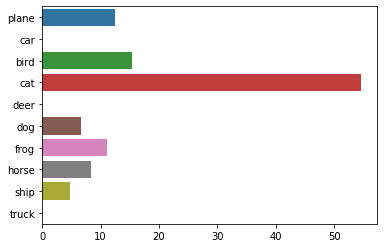

In [240]:
# barplot with class-specific accuracies.
# x-axis = % accuracy
ax4_augmentation = sns.barplot(x=ind_acc_augmentation4, y=class_list)

### Broad Interpretation

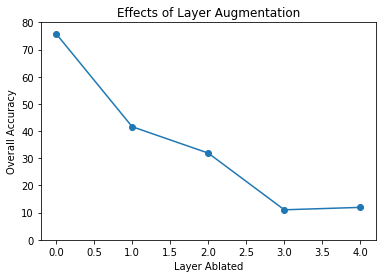

In [270]:
# compares all of the ablated models performance 
# Note: Layer 0 = Origial Model's Performance

accs_complete_augmentation = [original_acc, gen_acc_augmentation1, gen_acc_augmentation2,
                              gen_acc_augmentation3, gen_acc_augmentation4]

plt.plot(layers, accs_complete_augmentation, marker='o')
plt.ylim(0,80)
plt.title("Effects of Layer Augmentation")
plt.xlabel("Layer Ablated")
plt.ylabel("Overall Accuracy")
plt.show()

In [271]:
all_accuracies_complete = [acc_hist, ind_acc_augmentation1, ind_acc_augmentation2,
                           ind_acc_augmentation3, ind_acc_augmentation4]

plane_acc = [] ;  dog_acc = []
car_acc = []   ;  frog_acc = []
bird_acc = []  ;  horse_acc = []
cat_acc = []   ;  ship_acc = []
deer_acc = []  ;  truck_acc = []

for i in all_accuracies_complete:
    plane_acc.append(i[0])
    car_acc.append(i[1])
    bird_acc.append(i[2])
    cat_acc.append(i[3])
    deer_acc.append(i[4])
    dog_acc.append(i[5])
    frog_acc.append(i[6])
    horse_acc.append(i[7])
    ship_acc.append(i[8])
    truck_acc.append(i[9])

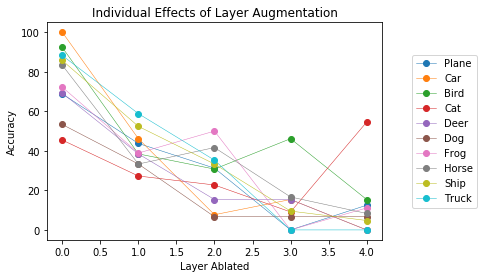

In [273]:
# Plotting
plt.plot(layers, plane_acc, marker='o', linewidth=0.5, label = 'Plane')
plt.plot(layers, car_acc, marker='o', linewidth=0.5, label = 'Car')
plt.plot(layers, bird_acc, marker='o', linewidth=0.5, label = 'Bird')
plt.plot(layers, cat_acc, marker='o', linewidth=0.5, label = 'Cat')
plt.plot(layers, deer_acc, marker='o', linewidth=0.5, label = 'Deer')
plt.plot(layers, dog_acc, marker='o', linewidth=0.5, label = 'Dog')
plt.plot(layers, frog_acc, marker='o', linewidth=0.5, label = 'Frog')
plt.plot(layers, horse_acc, marker='o', linewidth=0.5, label = 'Horse')
plt.plot(layers, ship_acc, marker='o', linewidth=0.5, label = 'Ship')
plt.plot(layers, truck_acc, marker='o', linewidth=0.5, label = 'Truck')

plt.ylim(-5,105)
plt.title("Individual Effects of Layer Augmentation")
plt.xlabel("Layer Ablated")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='right')
plt.show()

### Other References:

- https://pytorch.org/docs/stable/torchvision/models.html
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://cs231n.github.io/transfer-learning/
- https://blog.paperspace.com/pytorch-101-building-neural-networks/
- https://discuss.pytorch.org/t/how-to-draw-loss-per-epoch/22333